# Running MAGICC6

This notebook essentially copies over the corresponding notebook in the ```pymagicc``` repository (see [here](https://github.com/openscm/pymagicc/blob/probabilistic-run/notebooks/Parallel-Runs.ipynb)). For questions about how to run MAGICC6 in its probabilistic configuration and using MAGICC for scenario assessment, please contact Malte Meinshausen <malte.meinshausen@unimelb.edu.au;malte.meinshausen@climate-resource.com>, Zebedee Nicholls <zebedee.nicholls@climate-energy-college.org> and Jared Lewis <jared.lewis@climate-energy-college.org;jared.lewis@climate-resource.com>.

In [1]:
!conda list | grep -E 'openscm|pyam|pymagicc|silicone|aneris'

aneris-iamc               0.2.0+10.gf8d489a          pypi_0    pypi
openscm-runner            0.6.0                    pypi_0    pypi
openscm-units             0.2.0                    pypi_0    pypi
pyam-iamc                 0.10.0                   pypi_0    pypi
pymagicc                  2.0.0                    pypi_0    pypi
silicone                  1.0.2+35.g57ac254          pypi_0    pypi


In [2]:
import copy
import glob 
import logging 
import multiprocessing 
import os.path 
import random
from concurrent.futures import ProcessPoolExecutor 
from subprocess import CalledProcessError 

import f90nml 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import numpy as np 
from openscm_runner.adapters.utils._parallel_process import _parallel_process
from openscm_runner.adapters.magicc7._magicc_instances import _MagiccInstances
from scmdata import run_append 
import shutil 

import pymagicc 
import pandas as pd 

from utils import get_sr15_scenfiles

<IPython.core.display.Javascript object>

/opt/anaconda3/envs/institutional/lib/python3.7/site-packages/openscm_runner/progress.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

stderr_info_handler = logging.StreamHandler()
formatter = logging.Formatter("%(name)s - %(levelname)s: %(message)s")
stderr_info_handler.setFormatter(formatter)
logger.addHandler(stderr_info_handler)

openscm_runner_logger = logging.getLogger("openscm_runner")
openscm_runner_logger.setLevel(logging.INFO)
openscm_runner_logger.addHandler(stderr_info_handler)

In [4]:
# Number of MAGICC workers to use
NWORKERS = 4
#NWORKERS = 40

# Where MAGICC copies should be made 
MAGICC_ROOT_DIR = os.path.expanduser(
     os.path.join("~","magicc-workers")    
#    os.path.join("/data2/ubuntu-znicholls/magicc-workers/")    
)

# # Override where the MAGICC6 executable is 
# os.environ["MAGICC_EXECUTABLE_6"] = os.path.expanduser(
#     os.path.join(
#         '..','pymagicc','pymagicc','MAGICC6','run','magicc6.exe'
#     )
# )
magicc6_executable = pymagicc.MAGICC6().get_executable()
magicc6_executable

'/opt/anaconda3/envs/institutional/lib/python3.7/site-packages/pymagicc/MAGICC6/run/magicc6.exe'

# Parallel setup 

In [5]:
class MAGICC6Instances(_MagiccInstances):
    def get(self, root_dir=None, init_callback=None, init_callback_kwargs=None):
        magicc_version = 6  # hard-code for now
        key = (magicc_version, self._get_key())
        try:
            return self.instances[key]
        except KeyError:
            kwargs_init = {}
            if root_dir:
                kwargs_init["root_dir"] = self._generate_magicc_root(root_dir)

            # ensure pymagicc will behave itself
            pymagicc.config.config["EXECUTABLE_6"] = magicc6_executable
            magicc = pymagicc.MAGICC6(strict=False, **kwargs_init)
            magicc.create_copy()
            logger.info("Created new magicc instance: %s - %s", key, magicc.root_dir)

            self.instances[key] = magicc
            if init_callback_kwargs is None:
                init_callback_kwargs = {}

            if init_callback is not None:
                init_callback(magicc, **init_callback_kwargs)

            return magicc

In [6]:
shared_manager = multiprocessing.Manager()
shared_dict = shared_manager.dict()

if not os.path.isdir(MAGICC_ROOT_DIR):
    os.makedirs(MAGICC_ROOT_DIR)

def init_magicc_worker(dict_shared_instances, root_dir):
    logger.debug("Initialising process %s", multiprocessing.current_process())
    logger.debug("Existing instances %s", dict_shared_instances)

def _run_func(magicc, cfg):
    try:
        scenario = cfg.pop("scenario")
        res = magicc.run(**cfg, out_parameters=1)
        res["scenario"] = scenario
        res["run_id"] = cfg["run_id"]
        #res.set_meta(cfg["run_id"], "run_id")
        #res.set_meta(scenario, "scenario")
        
        return res
    except CalledProcessError as e:
        # Swallow the exception, but return None
        logger.debug("magicc run failed: {} (cfg: {})".format(e.stderr, cfg))
        return None

instances = MAGICC6Instances(existing_instances=shared_dict)




def _execute_run(cfg, run_func, setup_func):
    magicc = instances.get(root_dir=MAGICC_ROOT_DIR, init_callback=setup_func)

    return run_func(magicc, cfg)

def make_runs_list(cfgs):
    """
    Turn the configs into a list which can be run in parallel.
    
    Assigns ``run_id`` for each run if it's not already there.
    """
    out = [
        {
            "cfg": {**{"run_id": i}, **cfg},
            "run_func": _run_func,
            "setup_func": _setup_func,
        }
        for i, cfg in enumerate(cfgs)
    ]
    if not all(["scenario" in c["cfg"] for c in out]):
       raise KeyError("Please include a key 'scenario' in each config")
        
    return out

# Setup changes 

In [7]:
def _setup_func(magicc):
    logger.info(
        "Setting up MAGICC worker in %s", magicc.root_dir,
    )

# Runs

We first draw the parameter sets, define a list of SCEN files and then run through.

In [8]:
cfg_path = 'magicc_cfg'
cfg_files = os.listdir(cfg_path)
ar5_cfg = [x for x in cfg_files if "MAGTUNE_DRAWNSET_CDF_RogeljIPCCrepresent_" in x]

In [9]:
ar5_cfgs_loaded = [
    f90nml.read(os.path.join(cfg_path, f))['nml_allcfgs']
    for f in ar5_cfg
]
# ar5_cfgs_loaded

In [10]:
c4mip_cfgs = glob.glob(os.path.join("magicc_cfg_carbon_cycle", "MAGTUNE_C4MIP*.CFG"))
c4mip_cfgs

['magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_CCSM1.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_CLIMBER.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_IPSAL.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_BERN.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_LLNL.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_UMD2.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_UVIC.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_HADLEY.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_MPI.CFG',
 'magicc_cfg_carbon_cycle/MAGTUNE_C4MIP_FRCGC.CFG']

In [11]:
c4mip_cfgs_loaded = [
    f90nml.read(f)
    for f in c4mip_cfgs
]
c4mip_cfgs_loaded[0]

Namelist([('nml_allcfgs',
           Namelist([('co2_detrituspool_initial', 56.7203),
                     ('co2_feedbackfactor_detritus', -0.2798096),
                     ('co2_feedbackfactor_gpp', 0.008768277),
                     ('co2_feedbackfactor_respiration', -0.01609707),
                     ('co2_feedbackfactor_soil', 0.1522352),
                     ('co2_fertilization_factor', 0.4396698),
                     ('co2_fertilization_method', 1.811535),
                     ('co2_fraction_detritus_2_soil', 0.001035048),
                     ('co2_fraction_gpp_2_detritus', 0.3472068),
                     ('co2_fraction_gpp_2_plant', 0.4848129),
                     ('co2_fraction_plant_2_detritus', 0.9989998),
                     ('co2_gpp_initial', 66.5843),
                     ('co2_plantpool_initial', 870.4989),
                     ('co2_respiration_initial', 12.3181),
                     ('co2_soilpool_initial', 1028.056),
                     ('core_verticaldiffusivi

In [12]:
random.seed(10)

ar5_core_carbon_cycle_cfgs = []
for nml_raw in ar5_cfgs_loaded:
    ar5_core_carbon_cycle_cfgs.append({
        **random.choice(c4mip_cfgs_loaded)["nml_allcfgs"],
        **nml_raw,
    })
    
len(ar5_core_carbon_cycle_cfgs)

600

In [13]:
{**{"a": 3}, **{"a": 4}}

{'a': 4}

In [14]:
scen_file_dir = 'scen_files'
scens_to_run = [
    x for x in os.listdir(scen_file_dir) 
    if x.endswith('.SCEN') and 'BAU' not in x and 'STEPS' not in x
]
scens_to_run

['bp_Rapid_qrw.SCEN',
 'bp_Net_Zero_eqw.SCEN',
 'bp_Rapid_rms.SCEN',
 'weo_SDS_2020_qrw.SCEN',
 'weo_SDS_2020_rms.SCEN',
 'equinor_Rebalance_rms.SCEN',
 'ieasr15_NZ2021_rms.SCEN',
 'equinor_Rebalance_qrw.SCEN',
 'ieasr15_NZ2021_qrw.SCEN',
 'bp_Net_Zero_rms.SCEN',
 'bp_Rapid_eqw.SCEN',
 'bp_Net_Zero_qrw.SCEN',
 'weo_SDS_2020_eqw.SCEN',
 'equinor_Rebalance_eqw.SCEN',
 'ieasr15_NZ2021_eqw.SCEN',
 'shell_sky_eqw.SCEN',
 'shell_sky_qrw.SCEN',
 'shell_sky_rms.SCEN']

In [15]:
sr15_scen_file_dir = "sr15_scenfiles"
valid_sr15_scen_files = get_sr15_scenfiles(sr15_scen_file_dir)
valid_sr15_scen_files[:10]

['sr15_scenfiles/scenfiles/IPCCSR15_POLES ADVANCE_ADVANCE_2020_Med2C_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_POLES EMF33_EMF33_WB2C_none_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_REMIND 1.7_ADVANCE_2030_Med2C_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_MESSAGE V.3_GEA_Eff_1p5C_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_AIM 2.0_SSP5-60_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_POLES EMF33_EMF33_tax_lo_full_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_REMIND-MAgPIE 1.7-3.0_PEP_1p5C_red_eff_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_AIM 2.0_SSP1-Baseline_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_AIM 2.0_SocioeconomicFactorCM_SSP2_Bio_1p5Degree_GAS.SCEN',
 'sr15_scenfiles/scenfiles/IPCCSR15_POLES CDL_CD-LINKS_NPi2020_400_GAS.SCEN']

In [16]:
scens_to_run = (
    [os.path.join(scen_file_dir, s) for s in scens_to_run] 
#    + valid_sr15_scen_files[:5]
)
scens_to_run

['scen_files/bp_Rapid_qrw.SCEN',
 'scen_files/bp_Net_Zero_eqw.SCEN',
 'scen_files/bp_Rapid_rms.SCEN',
 'scen_files/weo_SDS_2020_qrw.SCEN',
 'scen_files/weo_SDS_2020_rms.SCEN',
 'scen_files/equinor_Rebalance_rms.SCEN',
 'scen_files/ieasr15_NZ2021_rms.SCEN',
 'scen_files/equinor_Rebalance_qrw.SCEN',
 'scen_files/ieasr15_NZ2021_qrw.SCEN',
 'scen_files/bp_Net_Zero_rms.SCEN',
 'scen_files/bp_Rapid_eqw.SCEN',
 'scen_files/bp_Net_Zero_qrw.SCEN',
 'scen_files/weo_SDS_2020_eqw.SCEN',
 'scen_files/equinor_Rebalance_eqw.SCEN',
 'scen_files/ieasr15_NZ2021_eqw.SCEN',
 'scen_files/shell_sky_eqw.SCEN',
 'scen_files/shell_sky_qrw.SCEN',
 'scen_files/shell_sky_rms.SCEN']

In [17]:
cfgs = []

all_scens = []
for scen in scens_to_run:
    scen_name = os.path.basename(scen)
    
    shutil.copyfile(
        scen,
        os.path.join(
            os.path.dirname(magicc6_executable), scen_name
        )
    )
    for nml_raw in ar5_core_carbon_cycle_cfgs:
        nml = copy.deepcopy(nml_raw)
        nml["file_emissionscenario"]=scen_name
        nml["scenario"] = scen_name.replace(".SCEN", "")  
        nml["out_keydata_1"] = 1
        nml["rf_total_runmodus"] = "ALL"
        nml["CO2_SWITCHFROMCONC2EMIS_YEAR"] = 2010
        nml["CH4_SWITCHFROMCONC2EMIS_YEAR"] = 2010
        nml["N2O_SWITCHFROMCONC2EMIS_YEAR"] = 2010
        nml["FGAS_SWITCHFROMCONC2EMIS_YEAR"] = 2010
        nml["MHALO_SWITCH_CONC2EMIS_YR"] = 2010
        nml["RF_VOLC_FUTR_MEANLASTXYEARS"] = 0
        nml["RF_VOLCANIC_HISTORIC_MEANZERO"] = 1
        nml["BCOC_SWITCHFROMRF2EMIS_YEAR"] = 2000
        # append
        cfgs.append(nml)
    
    tmp = pymagicc.io.MAGICCData(scen)
    tmp["scenario"] = scen_name.replace(".SCEN", "")  
    all_scens.append(tmp)
    
all_scens = run_append(all_scens)
len(cfgs)

10800

In [18]:
all_scens.head()

time                                                                                                        2000-01-01  \
climate_model model       region scenario     todo unit         variable                                                 
unspecified   unspecified World  bp_Rapid_qrw SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      6.7350   
                                                                Emissions|CO2|MAGICC AFOLU                      1.1488   
                                                   Mt CH4 / yr  Emissions|CH4                                 308.6022   
                                                   Mt N2ON / yr Emissions|N2O                                   5.8510   
                                                   Mt S / yr    Emissions|SOx                                  53.8412   

time                                                                                                        2001-01-01  \
climate_model model       region scenario     todo unit         variable                                                 
unspecified   unspecified World  bp_Rapid_qrw SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      6.8959   
                                                                Emissions|CO2|MAGICC AFOLU                      1.1320   
                                                   Mt CH4 / yr  Emissions|CH4                                 313.8872   
                                                   Mt N2ON / yr Emissions|N2O                                   5.9440   
                                                   Mt S / yr    Emissions|SOx                                  54.4191   

time                                                                                                        2002-01-01  \
climate_model model       region scenario     todo unit         variable                                                 
unspecified   unspecified World  bp_Rapid_qrw SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      6.9490   
                                                                Emissions|CO2|MAGICC AFOLU                      1.2317   
                                                   Mt CH4 / yr  Emissions|CH4                                 323.3211   
                                                   Mt N2ON / yr Emissions|N2O                                   6.0826   
                                                   Mt S / yr    Emissions|SOx                                  54.9961   

time                                                                                                        2003-01-01  \
climate_model model       region scenario     todo unit         variable                                                 
unspecified   unspecified World  bp_Rapid_qrw SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      7.2860   
                                                                Emissions|CO2|MAGICC AFOLU                      1.2257   
                                                   Mt CH4 / yr  Emissions|CH4                                 325.3228   
                                                   Mt N2ON / yr Emissions|N2O                                   6.0529   
                                                   Mt S / yr    Emissions|SOx                                  55.5716   

time                                                                                                        2004-01-01  \
climate_model model       region scenario     todo unit         variable                                                 
unspecified   unspecified World  bp_Rapid_qrw SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      7.6719   
                                                                Emissions|CO2|MAGICC AFOLU                      1.2429   
                                                   Mt CH4 / yr  Emissions|CH4               

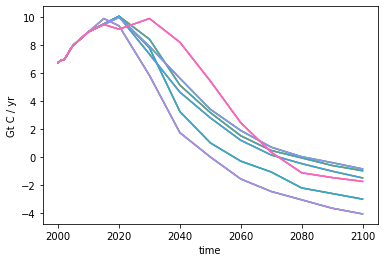

In [19]:
all_scens.filter(variable="Emissions|CO2*Fossil*").lineplot(legend=False)

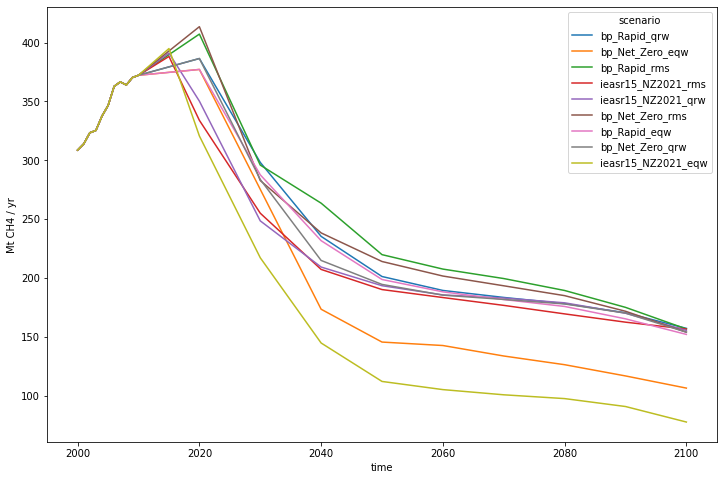

In [20]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
all_scens.filter(variable="Emissions|CH4", scenario=["bp*", "iea*"]).lineplot(legend=True, ax=ax)

In [21]:
runs = make_runs_list(cfgs)

In [22]:
try:
    pool = ProcessPoolExecutor(
        max_workers=NWORKERS,
        initializer=init_magicc_worker,
        initargs=(shared_dict, MAGICC_ROOT_DIR),
    )

    res_raw = _parallel_process(
        func=_execute_run,
        configuration=runs,
        pool=pool,
        config_are_kwargs=True,
        front_serial=2,
        front_parallel=2,
    )

    res = run_append([r for r in res_raw if r is not None])

finally:
    instances.cleanup()
    shared_manager.shutdown()
    pool.shutdown()

Front serial:   0%|          | 0.00/2.00 [00:00<?, ?it/s]

root - INFO: Created new magicc instance: (6, 'MainProcess') - /Users/gauravganti/magicc-workers/pymagicc-83eif2do
root - INFO: Setting up MAGICC worker in /Users/gauravganti/magicc-workers/pymagicc-83eif2do


Front parallel:   0%|          | 0.00/2.00 [00:00<?, ?it/s]

root - INFO: Created new magicc instance: (6, 'ForkProcess-3') - /Users/gauravganti/magicc-workers/pymagicc-evjqfc6r
root - INFO: Created new magicc instance: (6, 'ForkProcess-2') - /Users/gauravganti/magicc-workers/pymagicc-hdmlhihq
root - INFO: Setting up MAGICC worker in /Users/gauravganti/magicc-workers/pymagicc-hdmlhihq
root - INFO: Setting up MAGICC worker in /Users/gauravganti/magicc-workers/pymagicc-evjqfc6r


Parallel runs:   0%|          | 0.00/10.8k [00:00<?, ?it/s]

root - INFO: Created new magicc instance: (6, 'ForkProcess-5') - /Users/gauravganti/magicc-workers/pymagicc-2egd2drw
root - INFO: Created new magicc instance: (6, 'ForkProcess-4') - /Users/gauravganti/magicc-workers/pymagicc-6wz7kfk1
root - INFO: Setting up MAGICC worker in /Users/gauravganti/magicc-workers/pymagicc-2egd2drw
root - INFO: Setting up MAGICC worker in /Users/gauravganti/magicc-workers/pymagicc-6wz7kfk1
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /Users/gauravganti/magicc-workers/pymagicc-83eif2do
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /Users/gauravganti/magicc-workers/pymagicc-83eif2do
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /Users/gauravganti/magicc-workers/pymagicc-hdmlhihq
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /Users/gauravganti/magicc-workers/pymagicc-hdmlhihq
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /Users/gauravganti/magicc-workers/pym

# Test plotting

In [23]:
color = cm.rainbow(np.linspace(0,1,len(scens_to_run)))

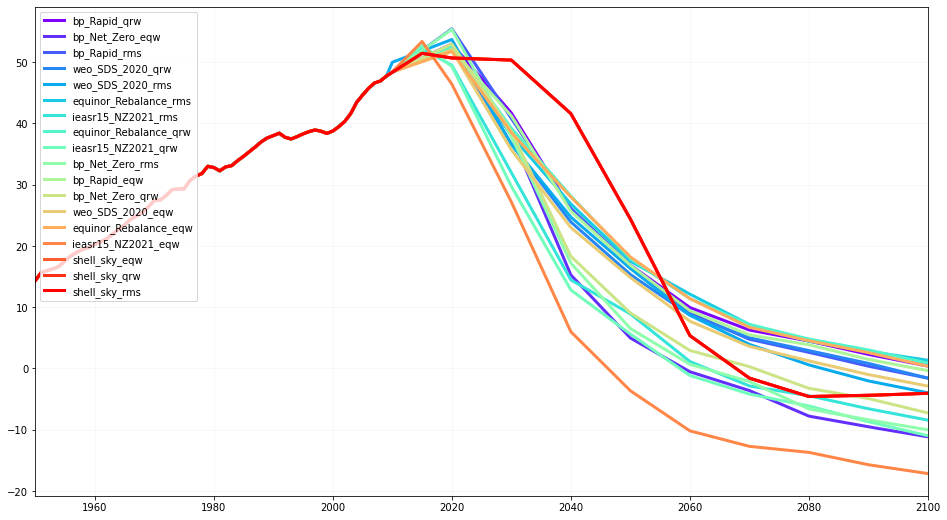

In [24]:
def _make_plot_ready(ts):
    ts.columns = ts.columns.map(lambda x: x.year)
    
    return ts

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

for scenario, colour in zip(res["scenario"].unique(), color):
    temperatures = res.filter(variable='KYOTOGHGS_GWPEMIS', region="World", scenario=scenario)
    x_axis = _make_plot_ready(temperatures.timeseries()).columns

    ax.plot(
        x_axis,
        _make_plot_ready(temperatures.process_over("run_id", "median")).values.T,
        color=colour,
        alpha=1,
        linewidth=3,
        label=scenario
    )
    ax.fill_between(
        x_axis,
        _make_plot_ready(temperatures.process_over("run_id", operation="quantile", q=0.17)).values.squeeze(),
        _make_plot_ready(temperatures.process_over("run_id", operation="quantile", q=0.83)).values.squeeze(),
        color=colour,
        alpha=0.2,
        zorder=1.5,
    );
    
ax.legend(loc=2)
ax.set_xlim(1950,2100)
ax.grid(alpha=0.1)

# Save out magicc results for further processing

In [25]:
date_str = pd.to_datetime('today').strftime('%Y-%m-%d')

In [26]:
sorted(res.filter(region="World").get_unique_meta("variable"))

['Atmospheric Concentrations|CH4',
 'Atmospheric Concentrations|CO2',
 'Atmospheric Concentrations|CO2 Equivalent',
 'Atmospheric Concentrations|CO2 Equivalent|Kyoto Gases',
 'Atmospheric Concentrations|N2O',
 'CO2I_GWPEMIS',
 'Emissions|BC|MAGICC AFOLU',
 'Emissions|BC|MAGICC Fossil and Industrial',
 'Emissions|CH4|MAGICC Fossil and Industrial',
 'Emissions|CO2',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'HEATUPTAKE_EBALANCE_TOTAL',
 'KYOTOGHGS_GWPEMIS',
 'NOXAIRNEW_EMIS',
 'Radiative Forcing',
 'Radiative Forcing|Aerosols|Direct Effect',
 'Radiative Forcing|Aerosols|Direct Effect|BC|MAGICC Fossil and Industrial',
 'Radiative Forcing|Aerosols|Direct Effect|SOx|MAGICC Fossil and Industrial',
 'Radiative Forcing|Aerosols|Indirect Effect',
 'Radiative Forcing|Anthropogenic',
 'Radiative Forcing|Aviation|Cirrus',
 'Radiative Forcing|Aviation|Contrail',
 'Radiative Forcing|Aviation|H2O',
 'Radiative Forcing|CH4',
 'Radiative Forcing|CH4 Oxidation Strato

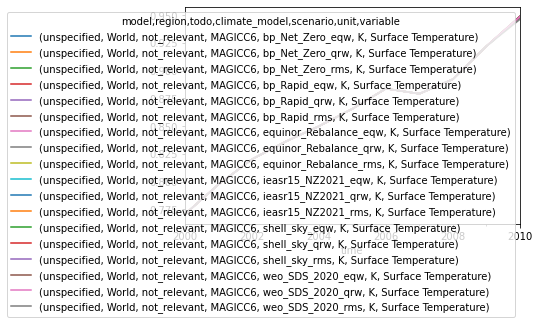

In [27]:
(
    res
    .filter(region="World", variable="Surface Temperature", year=range(2000, 2010 + 1))
    .process_over("run_id", "median")
    .T
    .plot()
)

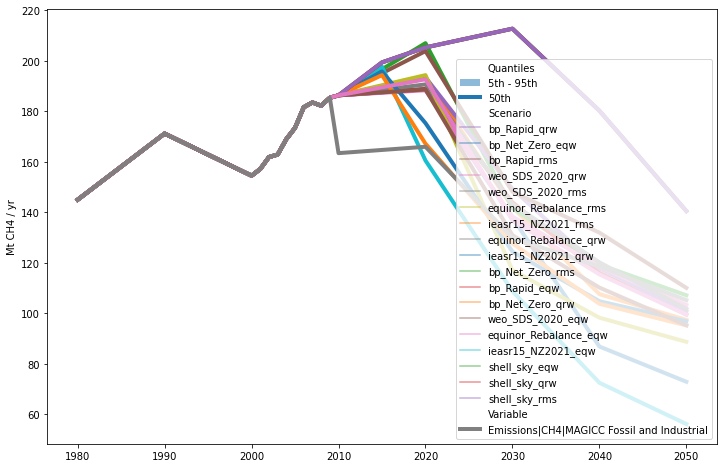

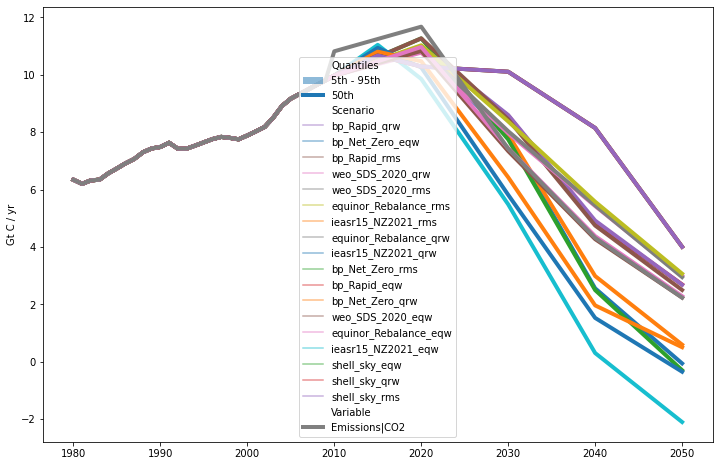

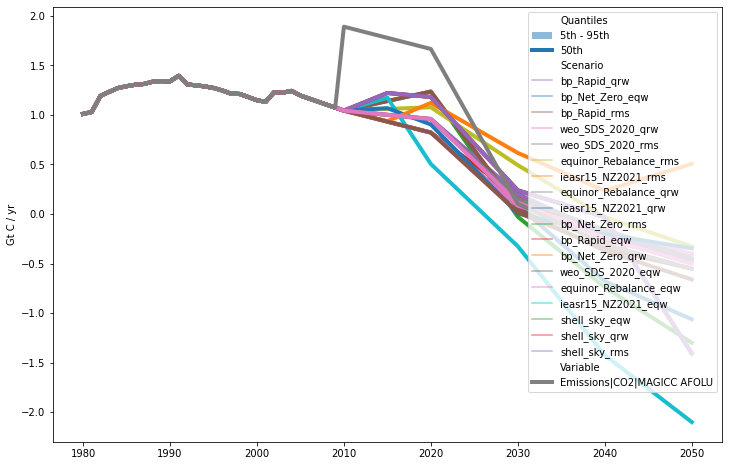

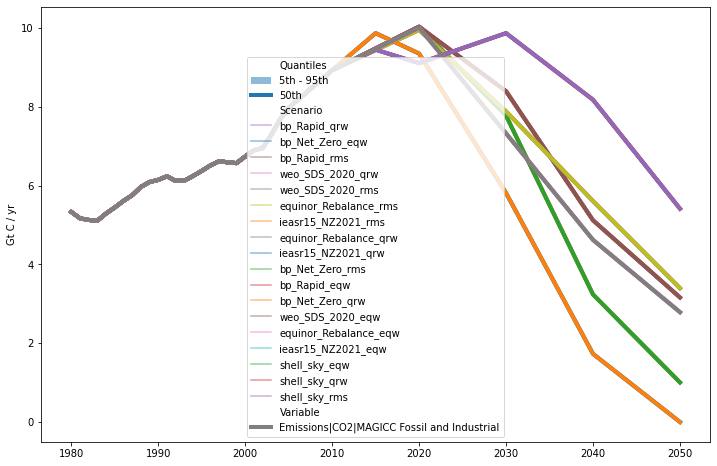

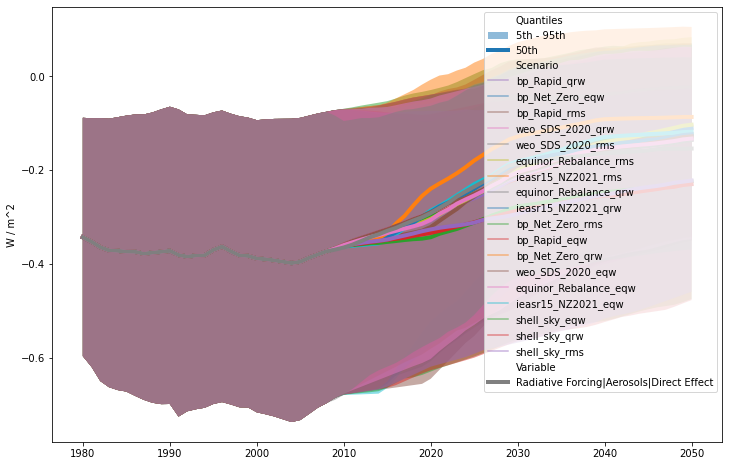

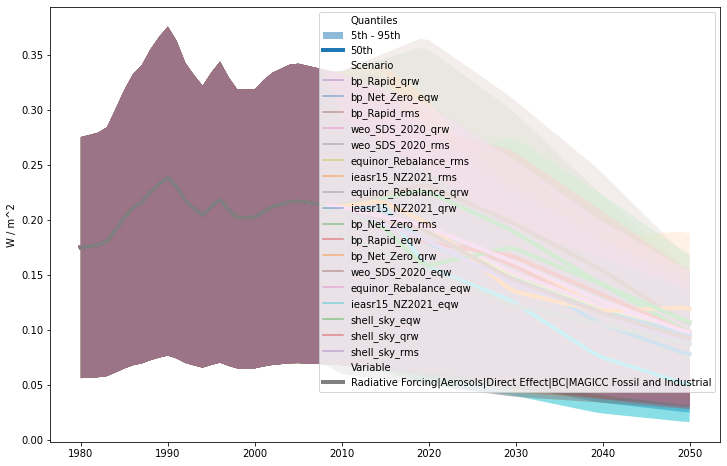

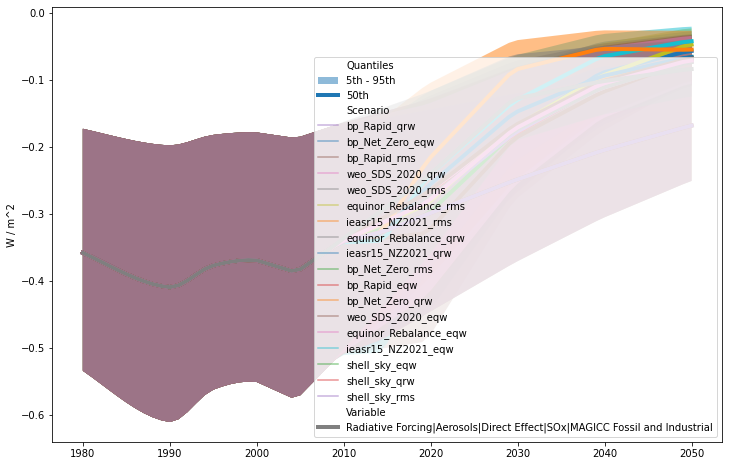

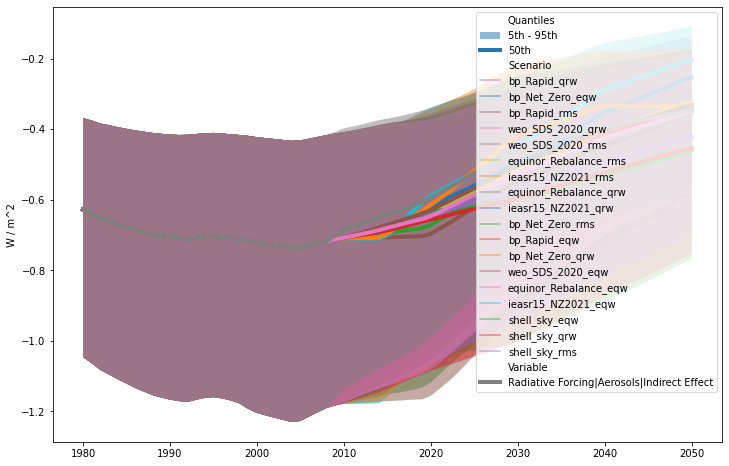

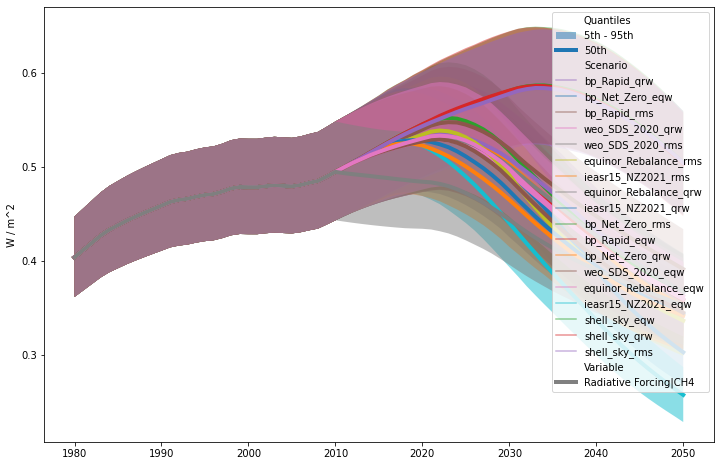

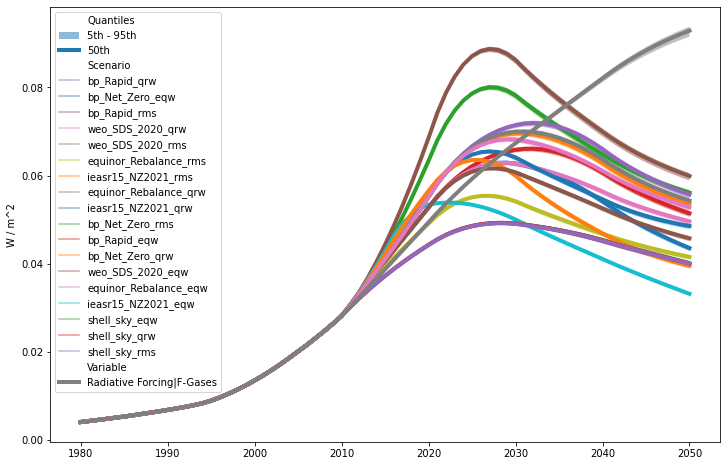

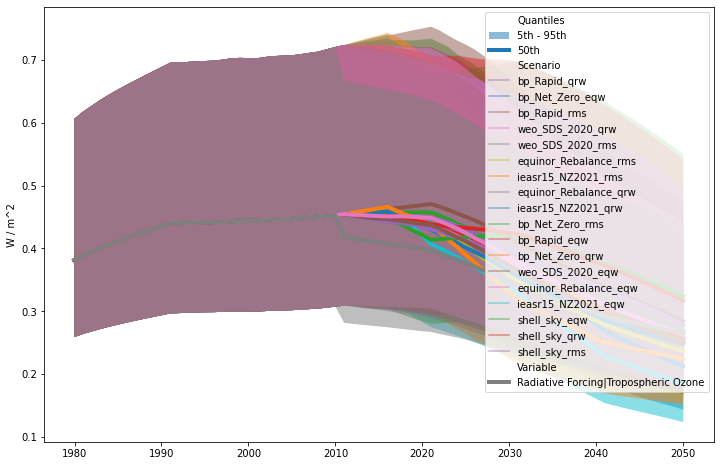

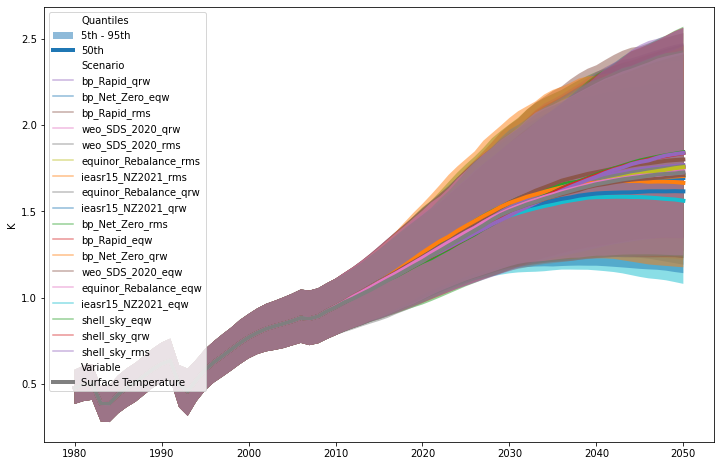

In [28]:
for vdf in res.filter(region="World", variable=[
    "Emissions|CH4*",
    "Emissions|CO2*",
    "Radiative Forcing|F-Gases",
#     "Radiative Forcing|Greenhouse Gases",
    "Radiative Forcing|Aerosols*",
#     "Radiative Forcing|Anthropogenic",
#     "Radiative Forcing|CO2",
    "Radiative Forcing|CH4",
#     "Radiative Forcing|N2O",
    "Radiative Forcing|*Ozone",
    "Surface Temperature",
]).groupby("variable"):
    ax = plt.figure(figsize=(12, 8)).add_subplot(111)
    (
        vdf
        .filter(year=range(1980, 2050 + 1))
        .plumeplot(
            quantiles_plumes=[((0.05, 0.95), 0.5), ((0.5,), 1.0)],
            linewidth=4,
            ax=ax, style_var="variable", quantile_over="run_id"
        )
    )
    plt.show()

In [29]:
# co2_rf_fraction = res.filter(variable="Radiative Forcing|CO2").divide(
#     res.filter(variable="Radiative Forcing|Anthropogenic"),
#     op_cols={"variable": "CO2 as % of total anthro forcing"}
# )

In [30]:
# ax = plt.figure(figsize=(12, 8)).add_subplot(111)
# co2_rf_fraction.filter(region="World").plumeplot(
#     quantiles_plumes=[((0.05, 0.95), 0.5), ((0.5,), 1.0)],
#     linewidth=4,
#     style_var="variable", 
#     quantile_over="run_id",
#     ax=ax
# )
# ax.grid()

In [31]:
res.filter(region='World', variable=[
    'Surface Temperature',
    'KYOTOGHGS_GWPEMIS',
    'Emissions|CO2|MAGICC Fossil and Industrial',
    'Emissions|CO2|MAGICC AFOLU',
]).to_csv(
    os.path.join('output','magicc_output_{}.csv'.format(date_str))
)

In [32]:
date_str

'2021-06-07'

In [36]:
with open('output/climate_configs_{}.txt'.format(date_str), 'w') as f:
    for item in cfgs:
        f.write("%s\n" % item)